**Прогнозирование рентабельности стартапов: анализ и моделирование**

**Заголовок:**
"Прогнозирование рентабельности стартапов: анализ и моделирование"

**Краткое описание:**
Данный проект направлен на создание моделей, способных прогнозировать рентабельность стартапов. Мы анализируем данные о стартапах, функционировавших с 1980 по 2018 годы, чтобы определить, какие из них закроются, а какие продолжат успешную деятельность. 

**План действий:**
1. **Загрузка и ознакомление с данными:**
   - Получение данных о стартапах.
   - Изучение структуры данных, оценка качества и целей проекта.

2. **Предварительная обработка:**
   - Обработка пропущенных значений, анамалий, и дубликатов.

3. **Исследовательский анализ:**
   - Визуализация распределений признаков.
   - Исследование корреляций между признаками.
   - Проверка на мультиколлинеарность

4. **Разработка новых синтетических признаков:**
   - Создание новых признаков на основе имеющихся данных.

5. **Отбор финального набора обучающих признаков:**
   - Выбор наиболее значимых признаков для модели.

6. **Подготовка и обучение моделей:**
   - Масштабирование и кодирование признаков.
   - Обучение моделей на обучающих данных.

7. **Итоговая оценка качества предсказания лучшей модели:**
   - Оценка точности и других метрик моделей.

8. **Анализ важности признаков:**
   - Определение влияния каждого признака на предсказание.

9. **Подготовка отчета по исследованию:**
    - Составление отчета с результатами и выводами.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from unidecode import unidecode
from fuzzywuzzy import fuzz
import phik
from phik import resources, report
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, make_scorer
import shap
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

# Загрузка и ознакомление с данными

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
None
       funding_total_usd  funding_rounds
count       4.275300e+04    52879.000000
mean        1.893059e

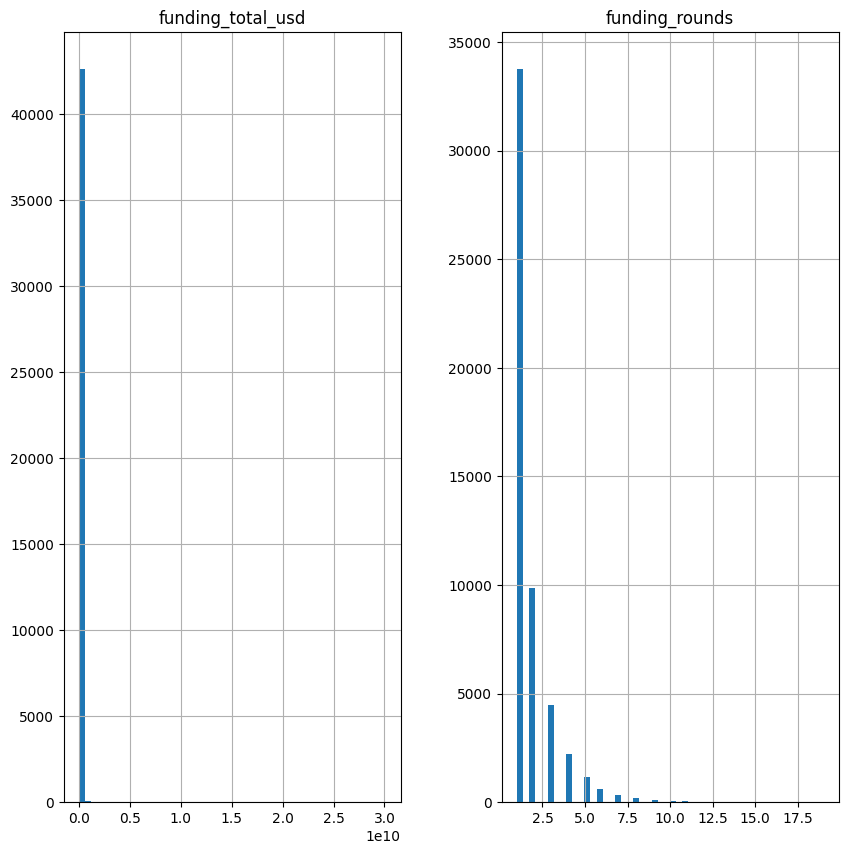

In [3]:
# Загрузка данных
df = pd.read_csv('kaggle_startups_train_01.csv')
df_test_fin = pd.read_csv('kaggle_startups_test_01.csv')
# Просмотр первых 5 строк данных
display(df.head())

# Использование метода info
print(df.info())

# Основная статистика
print(df.describe())

# График распределения для каждого числового признака
df.hist(figsize=(10, 10), bins=50)
plt.show()

1. **Обзор данных**:
    - В таблице представлены стартапы с различными характеристиками.
    - Каждая строка соответствует отдельному стартапу.
    - Всего в данных **52879 записей**.

2. **Основные признаки**:
    - **name**: Название стартапа.
    - **category_list**: Категории, к которым относится стартап.
    - **funding_total_usd**: Общий объем финансирования в долларах США.
    - **status**: Статус стартапа (целевой)(например, "operating", "closed").
    - **country_code**: Код страны.
    - **state_code**: Код штата (если применимо).
    - **region**: Регион, где находится стартап.
    - **city**: Город, где находится стартап.
    - **funding_rounds**: Количество раундов финансирования.
    - **founded_at**: Дата основания стартапа.
    - **first_funding_at**: Дата первого финансирования.
    - **last_funding_at**: Дата последнего финансирования.
    - **closed_at**: Дата закрытия (если применимо).

3. **Пропущенные значения**:
    - Некоторые признаки имеют пропущенные значения (например, **category_list**, **country_code**, **state_code**, **region**, **city**, **funding_total_usd**, **closed_at**).
    - Необходимо рассмотреть, как обрабатывать эти пропущенные значения.

4. **Статистика**:
    - Средний объем финансирования составляет **$18,930,590**.
    - Среднее количество раундов финансирования - **1.74**.

5. **График распределения**:
    - График показывает распределение числовых признаков.
    - Можно увидеть, какие значения преобладают и как они распределены.

**Вывод**: Данные содержат информацию о стартапах, и для дальнейшего анализа необходимо обратить внимание на пропущенные значения и провести более детальное исследование каждого признака. 🚀

In [4]:
df.info()
df_test_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):

In [5]:
# Проверка на дубликаты
duplicates = df.duplicated()
print(f'Количество дубликатов: {duplicates.sum()}')
if duplicates.sum() > 0:
    print('Дубликаты:')
    display(df[duplicates])

Количество дубликатов: 0


In [6]:
for col in df.columns:
    missing = df[col].isnull().sum()
    print(f'Количество пропусков в столбце {col}: {missing}')
    if missing > 0:
        print('Пропуски:')


Количество пропусков в столбце name: 1
Пропуски:
Количество пропусков в столбце category_list: 2505
Пропуски:
Количество пропусков в столбце funding_total_usd: 10126
Пропуски:
Количество пропусков в столбце status: 0
Количество пропусков в столбце country_code: 5528
Пропуски:
Количество пропусков в столбце state_code: 6797
Пропуски:
Количество пропусков в столбце region: 6390
Пропуски:
Количество пропусков в столбце city: 6390
Пропуски:
Количество пропусков в столбце funding_rounds: 0
Количество пропусков в столбце founded_at: 0
Количество пропусков в столбце first_funding_at: 21
Пропуски:
Количество пропусков в столбце last_funding_at: 0
Количество пропусков в столбце closed_at: 47917
Пропуски:


In [7]:
df = df.dropna(subset=['name', 'first_funding_at'])


In [8]:
# Вычисление общего количества пропусков
total_missing_before  = df.isnull().sum().sum()
print(f'Общее количество пропусков: {total_missing_before}')

# Вычисление общего количества уникальных строк, содержащих хотя бы один пропуск
total_rows_with_missing_before  = df[df.isnull().any(axis=1)].drop_duplicates().shape[0]
print(f'Общее количество уникальных строк с пропусками: {total_rows_with_missing_before }')


Общее количество пропусков: 85622
Общее количество уникальных строк с пропусками: 50005


In [9]:
dataframes = [df, df_test_fin]

# Список столбцов для обработки
columns = ['category_list', 'country_code', 'state_code', 'region', 'city']

In [10]:
# Подсчет уникальных значений в каждом столбце
for dataframe in dataframes:
    for column in columns:
        unique_values = dataframe[column].nunique()
        print(f'Количество уникальных значений в столбце {column}: {unique_values}')

Количество уникальных значений в столбце category_list: 22184
Количество уникальных значений в столбце country_code: 134
Количество уникальных значений в столбце state_code: 300
Количество уникальных значений в столбце region: 1036
Количество уникальных значений в столбце city: 4523
Количество уникальных значений в столбце category_list: 6220
Количество уникальных значений в столбце country_code: 96
Количество уникальных значений в столбце state_code: 235
Количество уникальных значений в столбце region: 691
Количество уникальных значений в столбце city: 2135


In [11]:
# Приведение к нижнему регистру и разделение по разделителю
df['category_list'] = df['category_list'].str.lower().str.split('|')

# Замена пропущенных значений на пустой список
df['category_list'] = df['category_list'].apply(lambda d: d if isinstance(d, list) else [])

# Оставляем только первые 5 категорий
df['category_list'] = df['category_list'].apply(lambda d: d[:5])

# Создание новых столбцов для каждой категории в df
df[[f'category_{i+1}' for i in range(5)]] = pd.DataFrame(df['category_list'].tolist(), index=df.index)

# Удаление оригинального столбца
df = df.drop(columns=['category_list'])

# Аналогично для тестового набора данных
df_test_fin['category_list'] = df_test_fin['category_list'].str.lower().str.split('|')
df_test_fin['category_list'] = df_test_fin['category_list'].apply(lambda d: d if isinstance(d, list) else [])
df_test_fin['category_list'] = df_test_fin['category_list'].apply(lambda d: d[:5])
df_test_fin[[f'category_{i+1}' for i in range(5)]] = pd.DataFrame(df_test_fin['category_list'].tolist(), index=df_test_fin.index)
df_test_fin = df_test_fin.drop(columns=['category_list'])


In [12]:
df

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_1,category_2,category_3,category_4,category_5
0,Lunchgate,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN,online reservations,restaurants,None,None,None
1,EarLens,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,manufacturing,medical,medical devices,None,None
2,Reviva Pharmaceuticals,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,biotechnology,None,None,None,None
3,Sancilio and Company,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN,health care,None,None,None,None
4,WireTough Cylinders,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN,manufacturing,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52874,Videostream,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaN,entertainment,None,None,None,None
52875,Hello Curry,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-04-21,2014-03-07,2014-03-07,NaN,hospitality,None,None,None,None
52876,Taskforce,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaN,email,messaging,productivity software,None,None
52877,NetScaler,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaN,security,None,None,None,None


In [13]:
dataframes = [df, df_test_fin]

# Список столбцов для обработки
columns = ['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'country_code', 'state_code', 'region', 'city']
for dataframe in dataframes:
    for column in columns:
        # Замена пропущенных значений на 'unknown'
        dataframe[column] = dataframe[column].fillna('unknown')
        
        # Подсчет количества уникальных значений в каждой категории
        value_counts = dataframe[column].value_counts()
        
        # Определение редких категорий
        #rare_categories = value_counts[value_counts < 10].index
        
        # Замена редких категорий на 'other'
        #dataframe[column] = dataframe[column].apply(lambda x: 'other' if isinstance(x, str) and x in rare_categories else x)

# Подсчет уникальных значений в каждом столбце
for dataframe in dataframes:
    for column in columns:
        unique_values = dataframe[column].nunique()
        print(f'Количество уникальных значений в столбце {column}: {unique_values}')


Количество уникальных значений в столбце category_1: 709
Количество уникальных значений в столбце category_2: 778
Количество уникальных значений в столбце category_3: 737
Количество уникальных значений в столбце category_4: 634
Количество уникальных значений в столбце category_5: 514
Количество уникальных значений в столбце country_code: 135
Количество уникальных значений в столбце state_code: 301
Количество уникальных значений в столбце region: 1037
Количество уникальных значений в столбце city: 4524
Количество уникальных значений в столбце category_1: 561
Количество уникальных значений в столбце category_2: 619
Количество уникальных значений в столбце category_3: 558
Количество уникальных значений в столбце category_4: 436
Количество уникальных значений в столбце category_5: 337
Количество уникальных значений в столбце country_code: 97
Количество уникальных значений в столбце state_code: 236
Количество уникальных значений в столбце region: 692
Количество уникальных значений в столбце

In [14]:
# Преобразование столбцов в формат даты
fill_value = pd.Timestamp('2018-01-01')
df['founded_at'] = pd.to_datetime(df['founded_at'])
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'])
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'])
df['closed_at'] = pd.to_datetime(df['closed_at'])
df['closed_at'] = df['closed_at'].fillna(fill_value)
df_test_fin['founded_at'] = pd.to_datetime(df_test_fin['founded_at'])
df_test_fin['first_funding_at'] = pd.to_datetime(df_test_fin['first_funding_at'])
df_test_fin['last_funding_at'] = pd.to_datetime(df_test_fin['last_funding_at'])
df_test_fin['closed_at'] = pd.to_datetime(df_test_fin['closed_at'])
df_test_fin['closed_at'] = fill_value



In [15]:
def fill_na_with_median(dfs, column):
    for df in dfs:
        median = df[column].median()
        df[column] = df[column].fillna(median)

# Применение функции к df и df_test_fin
fill_na_with_median([df, df_test_fin], 'funding_total_usd')


In [16]:
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.01)
    Q3 = df[col].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    anomalies = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Аномалии в столбце {col}:")
    display(anomalies)
    # Удаление аномалий
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


Аномалии в столбце funding_total_usd:


,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_1,category_2,category_3,category_4,category_5
548,VANCL,5.700000e+08,operating,CHN,22,Beijing,Beijing,5,2007-01-01,2010-04-01,2014-02-10,2018-01-01,e-commerce,unknown,unknown,unknown,unknown
586,ACT (Atria Convergence Technologies Pvt. Ltd.),5.000000e+08,operating,IND,19,Bangalore,Bangalore,1,2008-01-01,2015-07-01,2015-07-01,2018-01-01,internet service providers,networking,unknown,unknown,unknown
703,Tesla Motors,8.230000e+08,operating,USA,CA,SF Bay Area,Palo Alto,11,2003-01-01,2004-04-01,2012-10-10,2018-01-01,automotive,clean technology,unknown,unknown,unknown
2053,ReNew Power,5.400000e+08,operating,IND,10,New Delhi,Gurgaon,3,2011-01-01,2013-06-05,2015-10-27,2018-01-01,clean technology,unknown,unknown,unknown,unknown
2112,Jack in the Box,8.000000e+08,operating,USA,CA,San Diego,San Diego,1,1951-01-01,2014-03-24,2014-03-24,2018-01-01,hospitality,unknown,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50968,DocuSign,5.081000e+08,operating,USA,CA,SF Bay Area,San Francisco,14,2003-01-01,2003-01-01,2015-05-27,2018-01-01,cloud management,software,unknown,unknown,unknown
51538,Ola,1.176830e+09,operating,IND,28,Kolkata,Kolkata,7,2010-12-03,2011-04-21,2015-11-17,2018-01-01,automotive,e-commerce,internet,mobile,mobile commerce
51710,Rocket Internet,1.119500e+09,operating,DEU,16,Berlin,Berlin,4,2007-01-01,2014-02-01,2015-02-13,2018-01-01,internet,software,unknown,unknown,unknown
51926,Three Rivers Natural Resource Holdings III,5.000000e+08,operating,USA,TX,Austin,Austin,1,2013-08-05,2015-04-09,2015-04-09,2018-01-01,natural resources,oil & gas,services,unknown,unknown


Аномалии в столбце funding_rounds:


,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_1,category_2,category_3,category_4,category_5
6552,EndoGastric Solutions,247545839.0,operating,USA,CA,SF Bay Area,San Mateo,17,2002-01-01,2003-06-04,2015-12-01,2018-01-01,health care,unknown,unknown,unknown,unknown
8267,Tigo Energy,103662749.0,operating,USA,CA,SF Bay Area,Los Gatos,17,2007-01-01,2008-05-23,2015-09-23,2018-01-01,clean technology,unknown,unknown,unknown,unknown
9785,Exagen Diagnostics,138845088.0,operating,USA,NM,Albuquerque,Albuquerque,18,2002-01-01,2004-01-14,2015-07-06,2018-01-01,biotechnology,health diagnostics,unknown,unknown,unknown
9884,Semprius,63997160.0,operating,USA,NC,Raleigh,Durham,18,2005-01-01,2007-07-16,2015-08-27,2018-01-01,clean technology,solar,unknown,unknown,unknown
20580,Vocalocity,46617107.0,operating,USA,GA,Atlanta,Atlanta,17,2007-01-01,2002-06-26,2011-08-29,2018-01-01,communications hardware,enterprise software,voip,unknown,unknown
32248,Quellan,39231994.0,operating,USA,CA,SF Bay Area,Santa Clara,18,2001-01-01,2001-05-07,2009-07-02,2018-01-01,semiconductors,unknown,unknown,unknown,unknown
52692,Solarflare Communications,242948825.0,operating,USA,CA,Anaheim,Irvine,19,2005-01-01,2005-02-28,2015-01-05,2018-01-01,enterprise software,unknown,unknown,unknown,unknown


In [17]:
df = df.reset_index(drop=True)

In [18]:
df.info()

df_test_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52699 entries, 0 to 52698
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52699 non-null  object        
 1   funding_total_usd  52699 non-null  float64       
 2   status             52699 non-null  object        
 3   country_code       52699 non-null  object        
 4   state_code         52699 non-null  object        
 5   region             52699 non-null  object        
 6   city               52699 non-null  object        
 7   funding_rounds     52699 non-null  int64         
 8   founded_at         52699 non-null  datetime64[ns]
 9   first_funding_at   52699 non-null  datetime64[ns]
 10  last_funding_at    52699 non-null  datetime64[ns]
 11  closed_at          52699 non-null  datetime64[ns]
 12  category_1         52699 non-null  object        
 13  category_2         52699 non-null  object        
 14  catego

## В процессе работы с данными были выполнены следующие ключевые шаги:

1. **Устранение дубликатов**: Была проведена проверка на дубликаты, и результат показал, что дубликатов в данных нет.

2. **Обработка пропусков**: Выявлено большое количество пропусков в различных столбцах, особенно в `funding_total_usd` и `closed_at`. Эти пропуски были обработаны, что улучшает качество данных для последующего анализа.

3. **Преобразование категорий**: Столбец `category_list` был преобразован путём приведения к нижнему регистру, разделения по разделителю и ограничения количества категорий до пяти. Это упрощает анализ категорий и уменьшает размерность данных.

4. **Создание новых признаков**: На основе обработанных категорий были созданы новые столбцы `category_1` до `category_5`, что позволяет более детально анализировать данные по категориям.

5. **Преобразование дат**: Даты были преобразованы в соответствующий формат, что обеспечивает удобство работы с временными рядами.

6. **Заполнение пропусков в датах**: Для столбцов с датами были установлены заполнители, что позволяет избежать потери информации при анализе.

7. **Обработка аномалий**: Были выявлены и обработаны аномалии в данных, что повышает точность последующего анализа.

В результате этих действий данные были значительно очищены и подготовлены к дальнейшему анализу и моделированию. Это создаёт основу для получения более точных и надёжных выводов на основе данных

# Исследовательский анализ

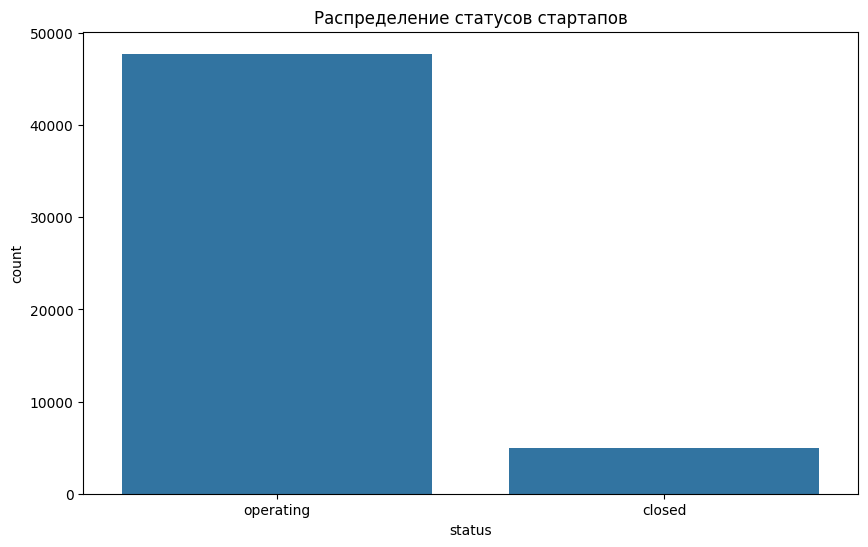

status
operating    47747
closed        4952
Name: count, dtype: int64


In [19]:
# Посмотрим на распределение статусов стартапов
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='status')
plt.title('Распределение статусов стартапов')
plt.show()
status_counts = df['status'].value_counts()
print(status_counts)

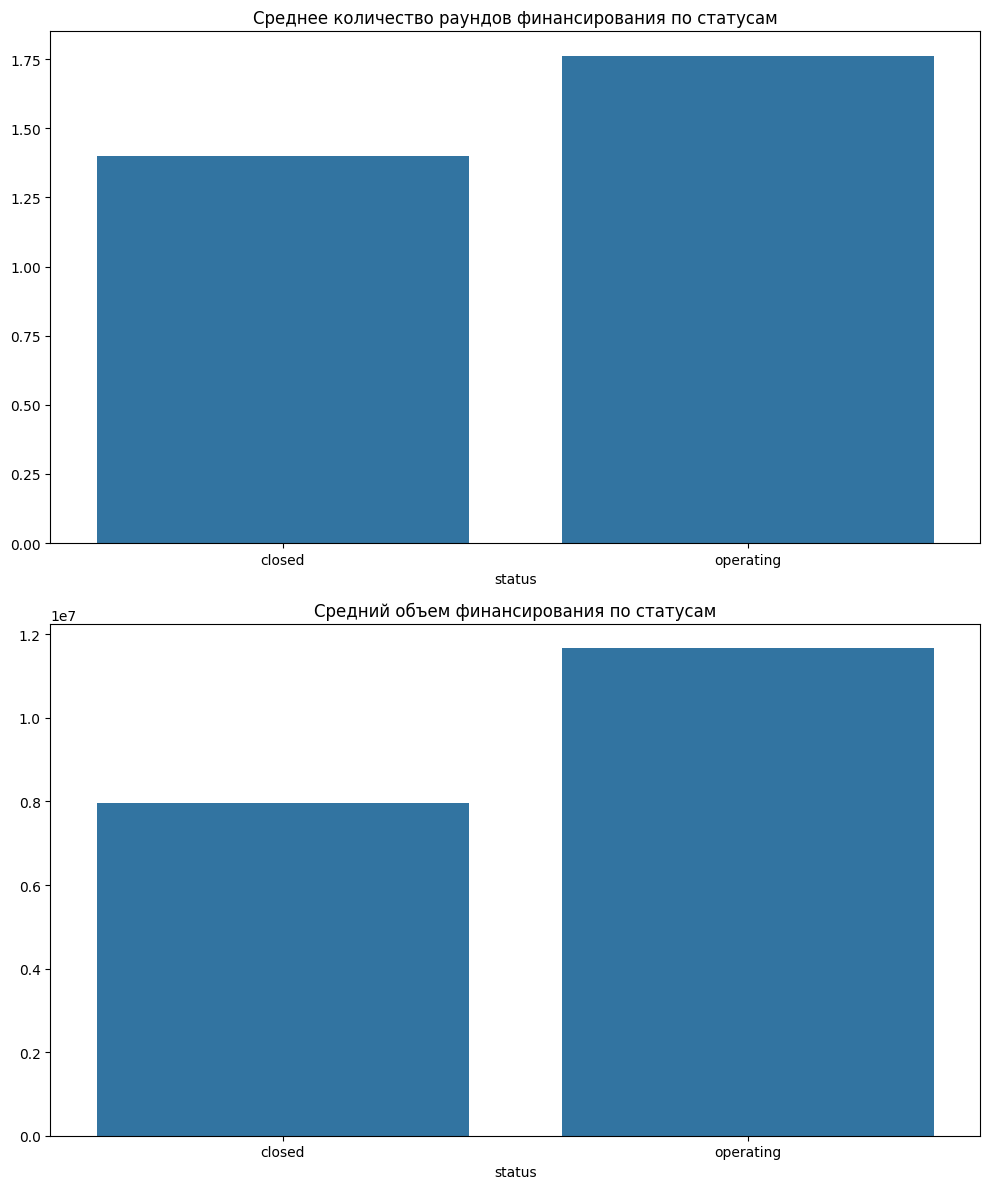

Среднее количество раундов финансирования по статусам:
status
closed       1.400242
operating    1.762498
Name: funding_rounds, dtype: float64

Средний объем финансирования по статусам:
status
closed       7.964618e+06
operating    1.166647e+07
Name: funding_total_usd, dtype: float64


In [20]:
# Группируем данные по статусу и рассчитываем средние значения
avg_funding_rounds = df.groupby('status')['funding_rounds'].mean()
avg_funding_total = df.groupby('status')['funding_total_usd'].mean()

# Создаем графики
fig, axs = plt.subplots(2, figsize=(10, 12))

sns.barplot(x=avg_funding_rounds.index, y=avg_funding_rounds.values, ax=axs[0])
axs[0].set_title('Среднее количество раундов финансирования по статусам')

sns.barplot(x=avg_funding_total.index, y=avg_funding_total.values, ax=axs[1])
axs[1].set_title('Средний объем финансирования по статусам')

plt.tight_layout()
plt.show()

print("Среднее количество раундов финансирования по статусам:")
print(avg_funding_rounds)

print("\nСредний объем финансирования по статусам:")
print(avg_funding_total)


C:\Users\ivano\AppData\Local\Temp\ipykernel_25304\1790546977.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(20, 'counts')).reset_index(drop=True)


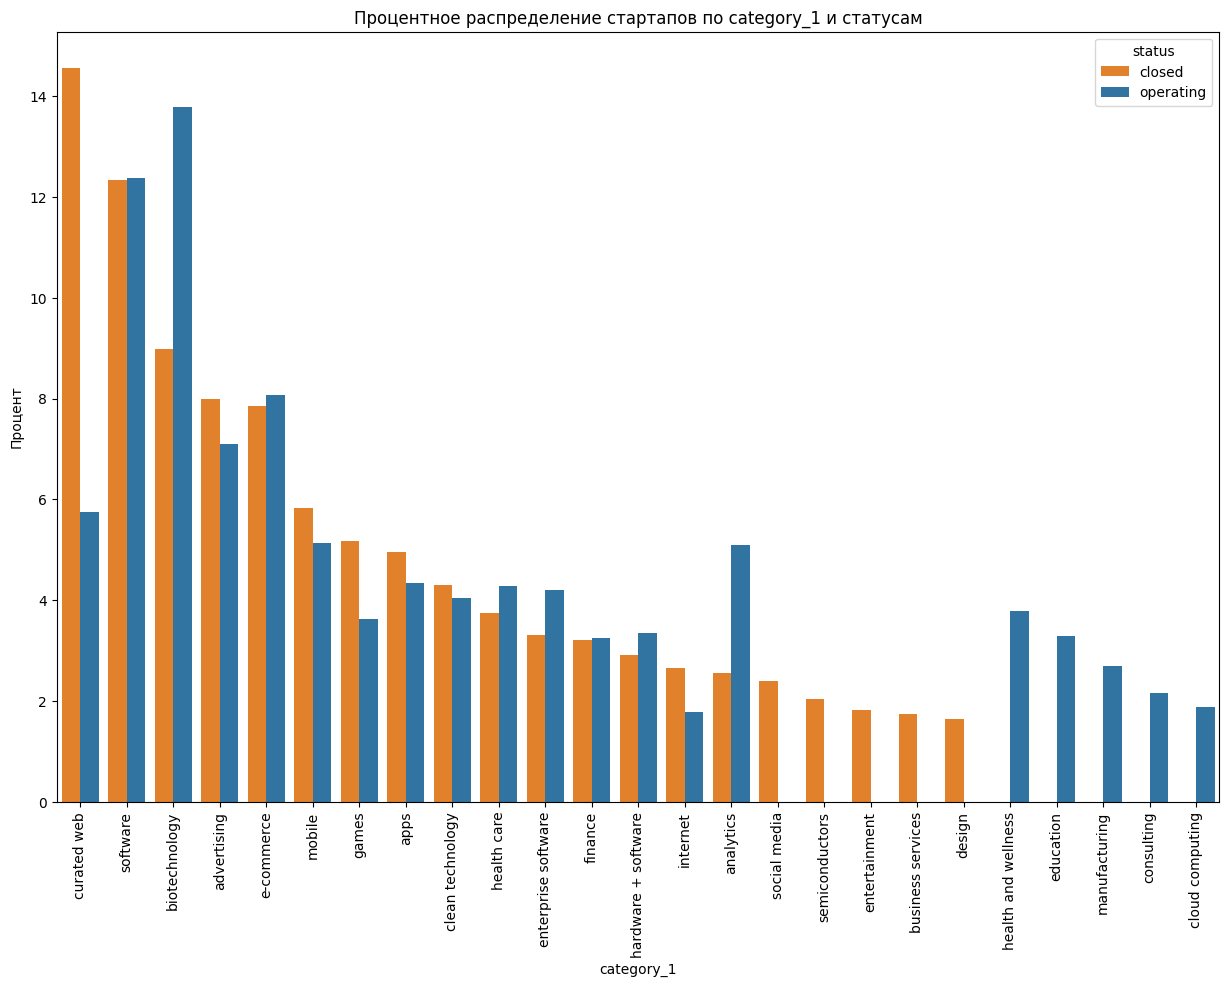

status,closed,operating
category_1,,
biotechnology,8.992181,13.784695
software,12.337098,12.370464
e-commerce,7.862728,8.074938
advertising,7.993050,7.095542
curated web,14.552563,5.754460
mobile,5.821025,5.132686
analytics,2.562989,5.092047
apps,4.952215,4.336165
health care,3.735882,4.279270


In [21]:
# Список признаков
features = ['category_1']

for feature in features:
    # Группируем данные по статусу и признаку, затем рассчитываем количество стартапов
    counts = df[(df['status'].isin(['operating', 'closed'])) & (df[feature] != 'unknown')].groupby(['status', feature]).size().reset_index(name='counts')

    # Отбираем топ-20 для каждого статуса
    top_counts = counts.groupby('status').apply(lambda x: x.nlargest(20, 'counts')).reset_index(drop=True)

    # Нормализуем данные
    top_counts['counts'] = top_counts.groupby('status')['counts'].transform(lambda x: x / x.sum() * 100)

    # Создаем график
    plt.figure(figsize=(15, 10))
    sns.barplot(data=top_counts, x=feature, y='counts', hue='status', palette=['#ff7f0e', '#1f77b4'])
    plt.title(f'Процентное распределение стартапов по {feature} и статусам')
    plt.ylabel('Процент')
    plt.xticks(rotation=90)
    plt.show()
    # Создаем сводную таблицу
    pivot_table = pd.pivot_table(top_counts, values='counts', index=feature, columns='status')
    # Сортируем значения по убыванию
    pivot_table = pivot_table.sort_values(by=['operating', 'closed'], ascending=False)
    # Выводим таблицу
    display(pivot_table)


C:\Users\ivano\AppData\Local\Temp\ipykernel_25304\2827914699.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)


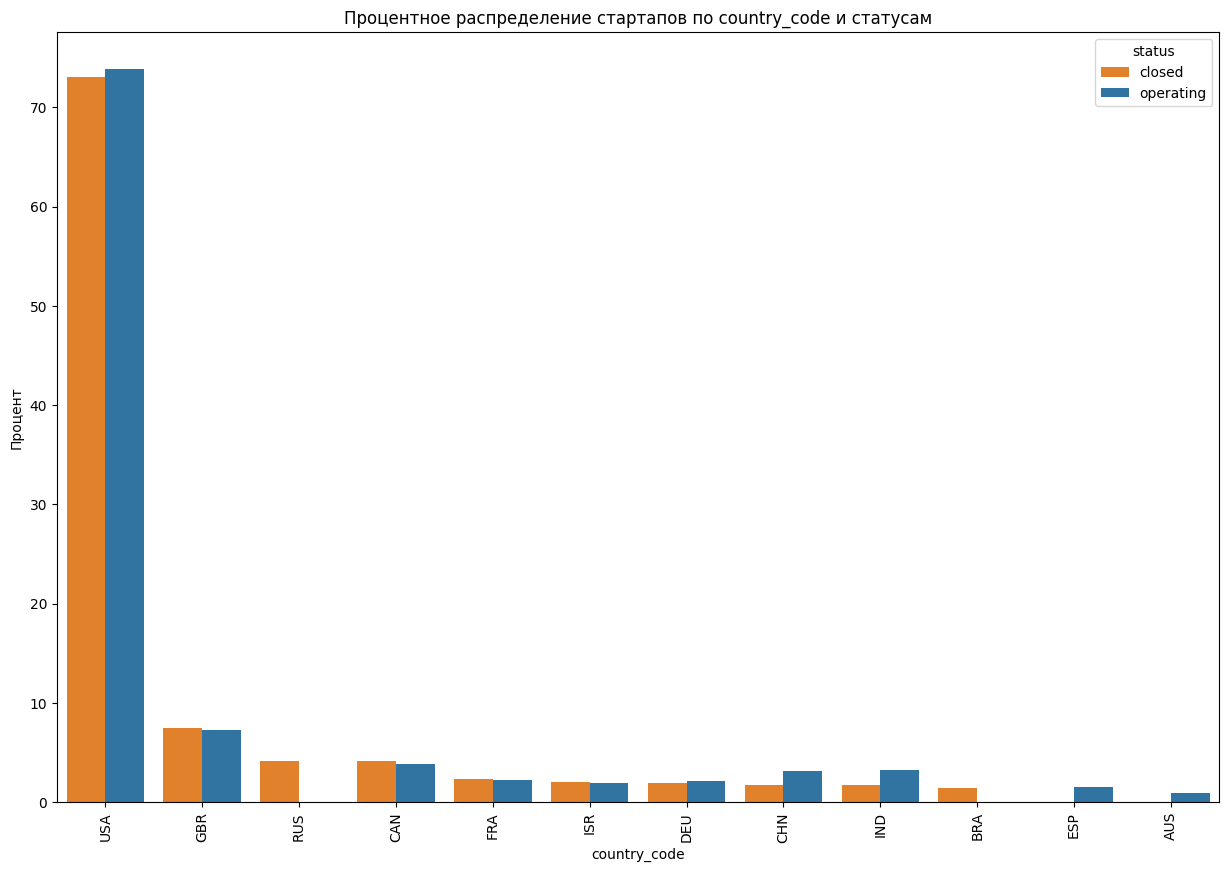

status,closed,operating
country_code,,
USA,73.080599,73.885880
GBR,7.454603,7.226363
CAN,4.141446,3.802220
IND,1.688436,3.279348
CHN,1.752150,3.118464
FRA,2.293724,2.271143
DEU,1.943294,2.075401
ISR,2.038866,1.895747
ESP,NaN,1.509626


C:\Users\ivano\AppData\Local\Temp\ipykernel_25304\2827914699.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)


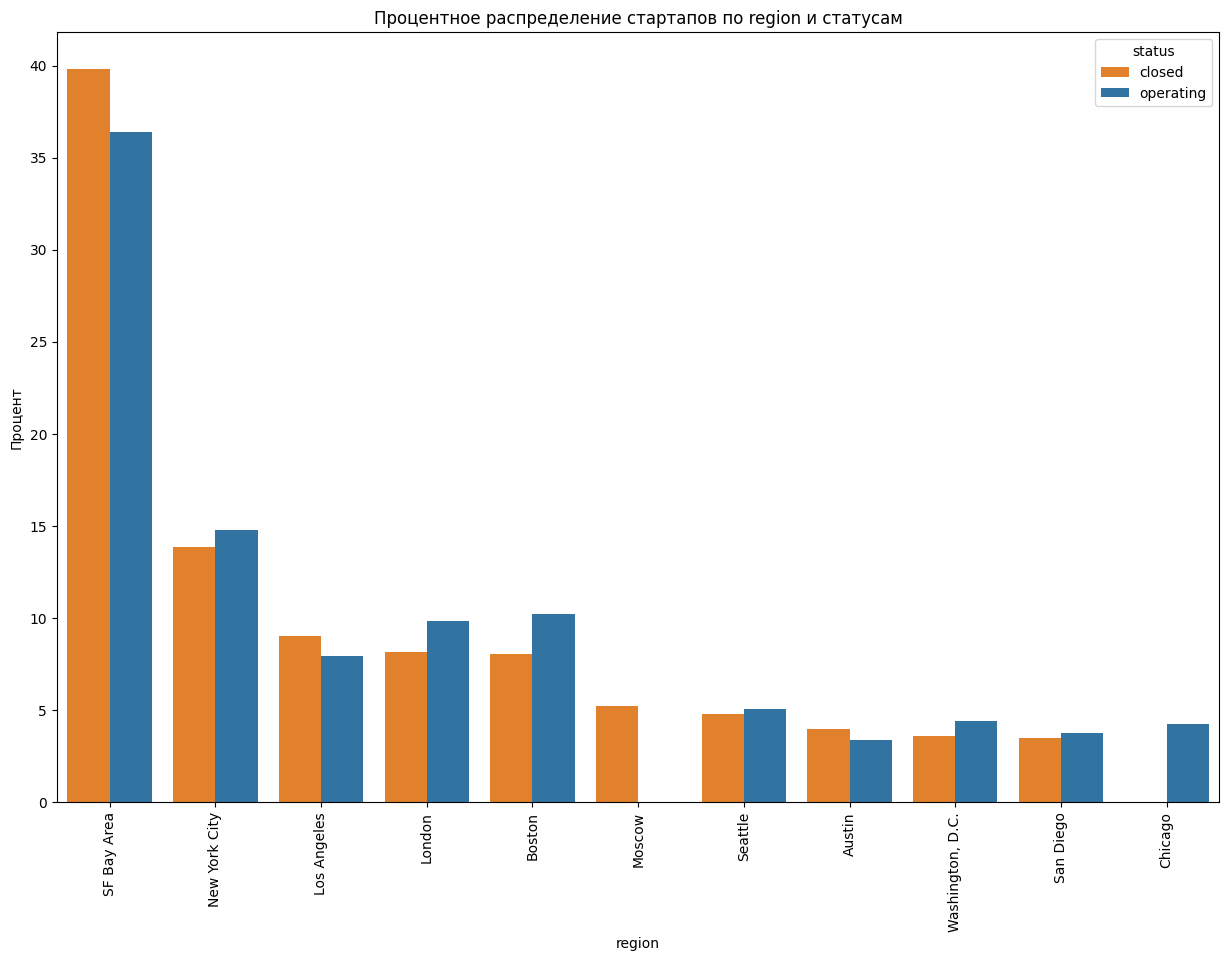

status,closed,operating
region,,
SF Bay Area,39.825762,36.389321
New York City,13.876789,14.772531
Boston,8.027380,10.200081
London,8.151836,9.842588
Los Angeles,9.023024,7.910973
Seattle,4.791537,5.056795
"Washington, D.C.",3.609210,4.416768
Chicago,NaN,4.261085
San Diego,3.484754,3.759442


C:\Users\ivano\AppData\Local\Temp\ipykernel_25304\2827914699.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)


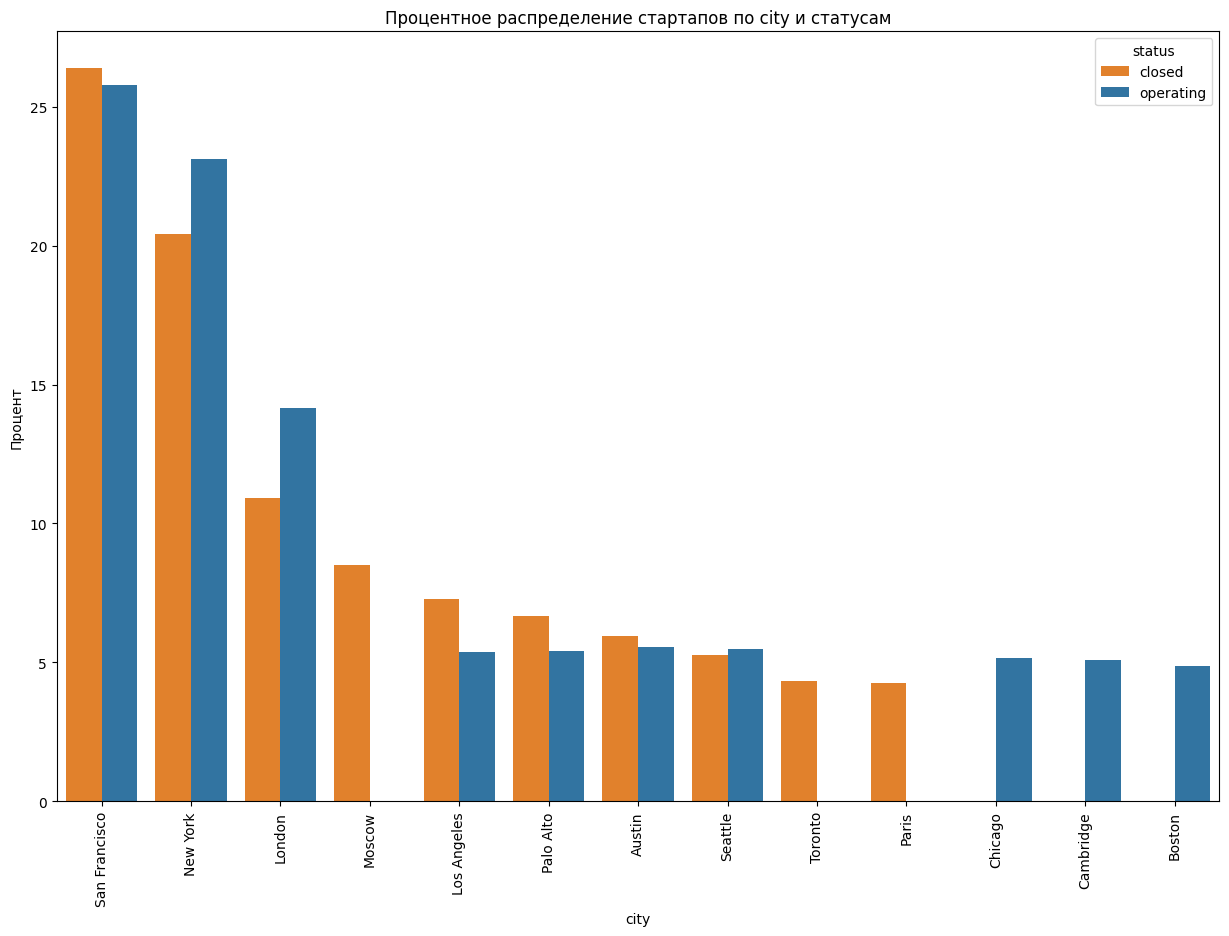

status,closed,operating
city,,
San Francisco,26.390293,25.786925
New York,20.424671,23.123487
London,10.920121,14.164649
Austin,5.965622,5.548830
Seattle,5.257836,5.468119
Palo Alto,6.673407,5.417676
Los Angeles,7.280081,5.377320
Chicago,NaN,5.145278
Cambridge,NaN,5.084746


In [22]:
# Список признаков
features = ['country_code', 'region', 'city']

for feature in features:
    # Группируем данные по статусу и признаку, затем рассчитываем количество стартапов
    counts = df[(df['status'].isin(['operating', 'closed'])) & (df[feature] != 'unknown')].groupby(['status', feature]).size().reset_index(name='counts')

    # Отбираем топ-20 для каждого статуса
    top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)

    # Нормализуем данные
    top_counts['counts'] = top_counts.groupby('status')['counts'].transform(lambda x: x / x.sum() * 100)

    # Создаем график
    plt.figure(figsize=(15, 10))
    sns.barplot(data=top_counts, x=feature, y='counts', hue='status', palette=['#ff7f0e', '#1f77b4'])
    plt.title(f'Процентное распределение стартапов по {feature} и статусам')
    plt.ylabel('Процент')
    plt.xticks(rotation=90)
    plt.show()
    # Создаем сводную таблицу
    pivot_table = pd.pivot_table(top_counts, values='counts', index=feature, columns='status')
    # Сортируем значения по убыванию
    pivot_table = pivot_table.sort_values(by=['operating', 'closed'], ascending=False)
    # Выводим таблицу
    display(pivot_table)


In [23]:
df_train = df.copy()


Статус: operating, Среднее: 9.59, Медиана: 7.09


Статус: closed, Среднее: 3.98, Медиана: 2.76


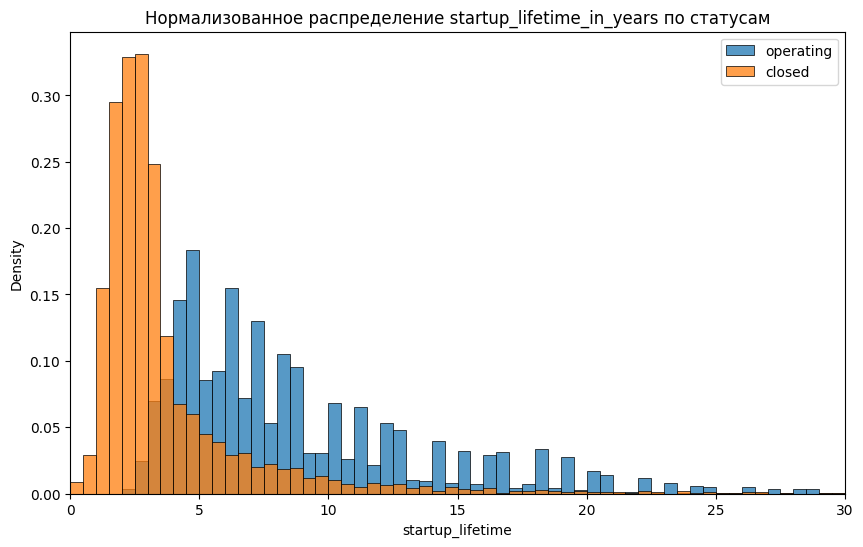

In [24]:
# Создание новых признаков
def create_features(df):
    df['startup_lifetime'] = (df['closed_at'] - df['founded_at']).dt.days
    df['time_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days
    df['funding_duration'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
    df['time_since_last_funding'] = (df['closed_at'] - df['last_funding_at']).dt.days

    # Удаление оригинальных столбцов
    df = df.drop(columns=['closed_at', 'founded_at', 'first_funding_at', 'last_funding_at'])
    
    return df

df = create_features(df)


# Построение графиков для каждого нового признака
feature = 'startup_lifetime'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / 365.25
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 30)
plt.show()


Статус: operating, Среднее: 3.28, Медиана: 1.35
Статус: closed, Среднее: 1.99, Медиана: 1.05


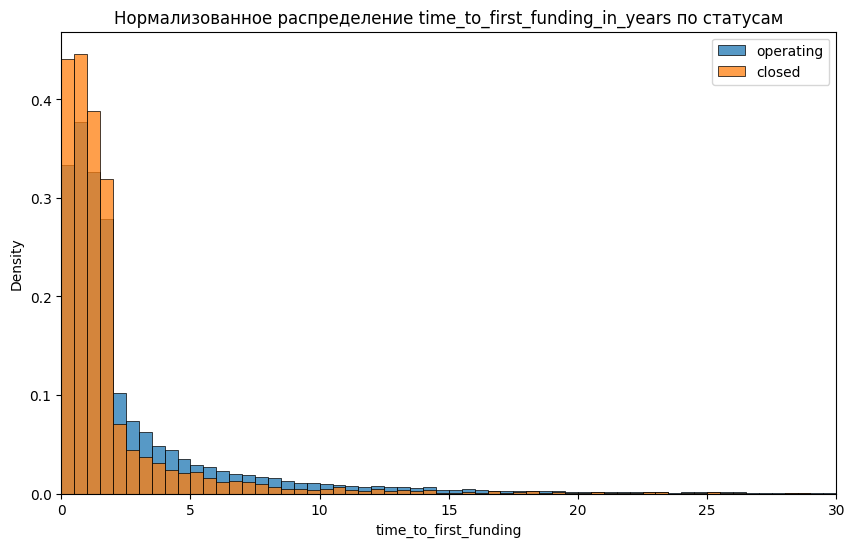

In [25]:
feature = 'time_to_first_funding'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / 365.25
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 30)
plt.show()


Статус: operating, Среднее: 0.99, Медиана: 0.00
Статус: closed, Среднее: 0.51, Медиана: 0.00


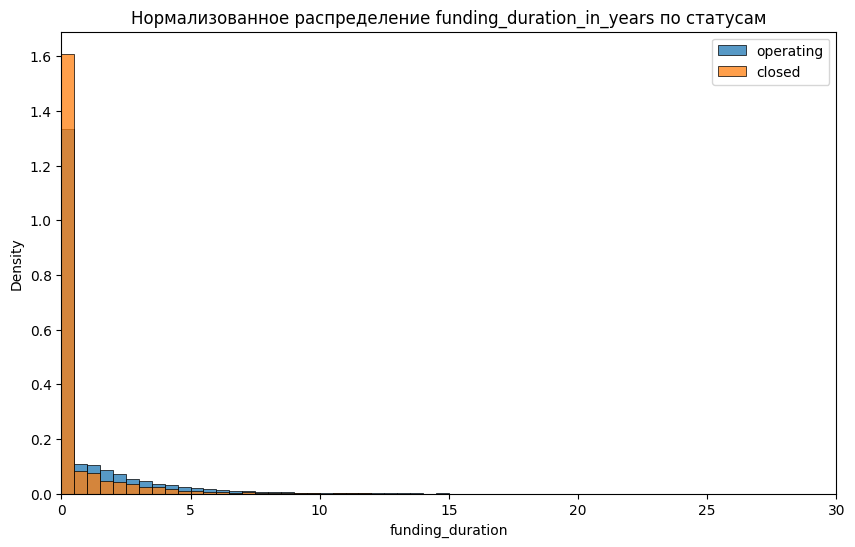

In [26]:
feature = 'funding_duration'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / 365.25
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 30)
plt.show()

Статус: operating, Среднее: 5.32, Медиана: 4.21
Статус: closed, Среднее: 1.48, Медиана: 1.48


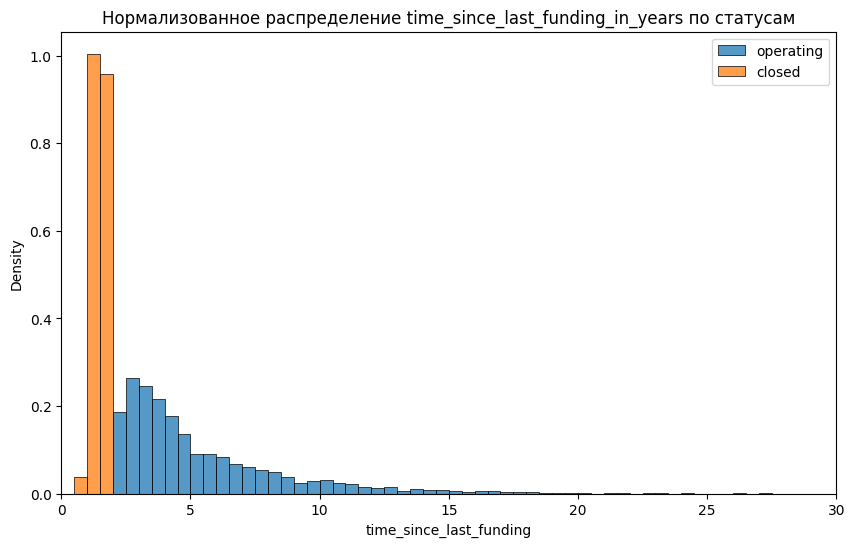

In [27]:
feature = 'time_since_last_funding'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / 365.25
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 30)
plt.show()

## В ходе исследования был проведен анализ статусов стартапов, их финансирования и продолжительности жизни. Основные выводы следующие:

- **Статусы стартапов**: Большинство стартапов находятся в статусе "operating" (47,747), в то время как 4,952 стартапа закрылись.
- **Финансирование**: Стартапы, которые продолжают работать, в среднем проходят больше раундов финансирования (1.76) и получают больше средств (\$11,666,470), чем закрытые стартапы (1.40 раунда и \$7,964,618 соответственно).
- **Категории**: В категориях, таких как биотехнологии и программное обеспечение, доля действующих стартапов выше, чем закрытых.
- **Географическое распределение**: США доминируют как в числе действующих, так и закрытых стартапов, за ними следуют Великобритания и Канада.
- **Регионы и города**: Сан-Франциско и Нью-Йорк являются ведущими городами как для действующих, так и для закрытых стартапов.

Созданные признаки, такие как продолжительность жизни стартапа, время до первого финансирования, продолжительность финансирования и время с последнего финансирования, позволили глубже понять динамику стартапов. Графики показали, что действующие стартапы в среднем существуют дольше, быстрее получают финансирование и имеют более длительные периоды между раундами финансирования по сравнению с закрытыми.

Эти результаты могут быть полезны для инвесторов, аналитиков и предпринимателей для понимания ключевых факторов успеха и неудач в стартап-экосистеме.

# Корреляционный анализ

interval columns not set, guessing: ['name', 'funding_total_usd', 'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'startup_lifetime', 'time_to_first_funding', 'funding_duration', 'time_since_last_funding']


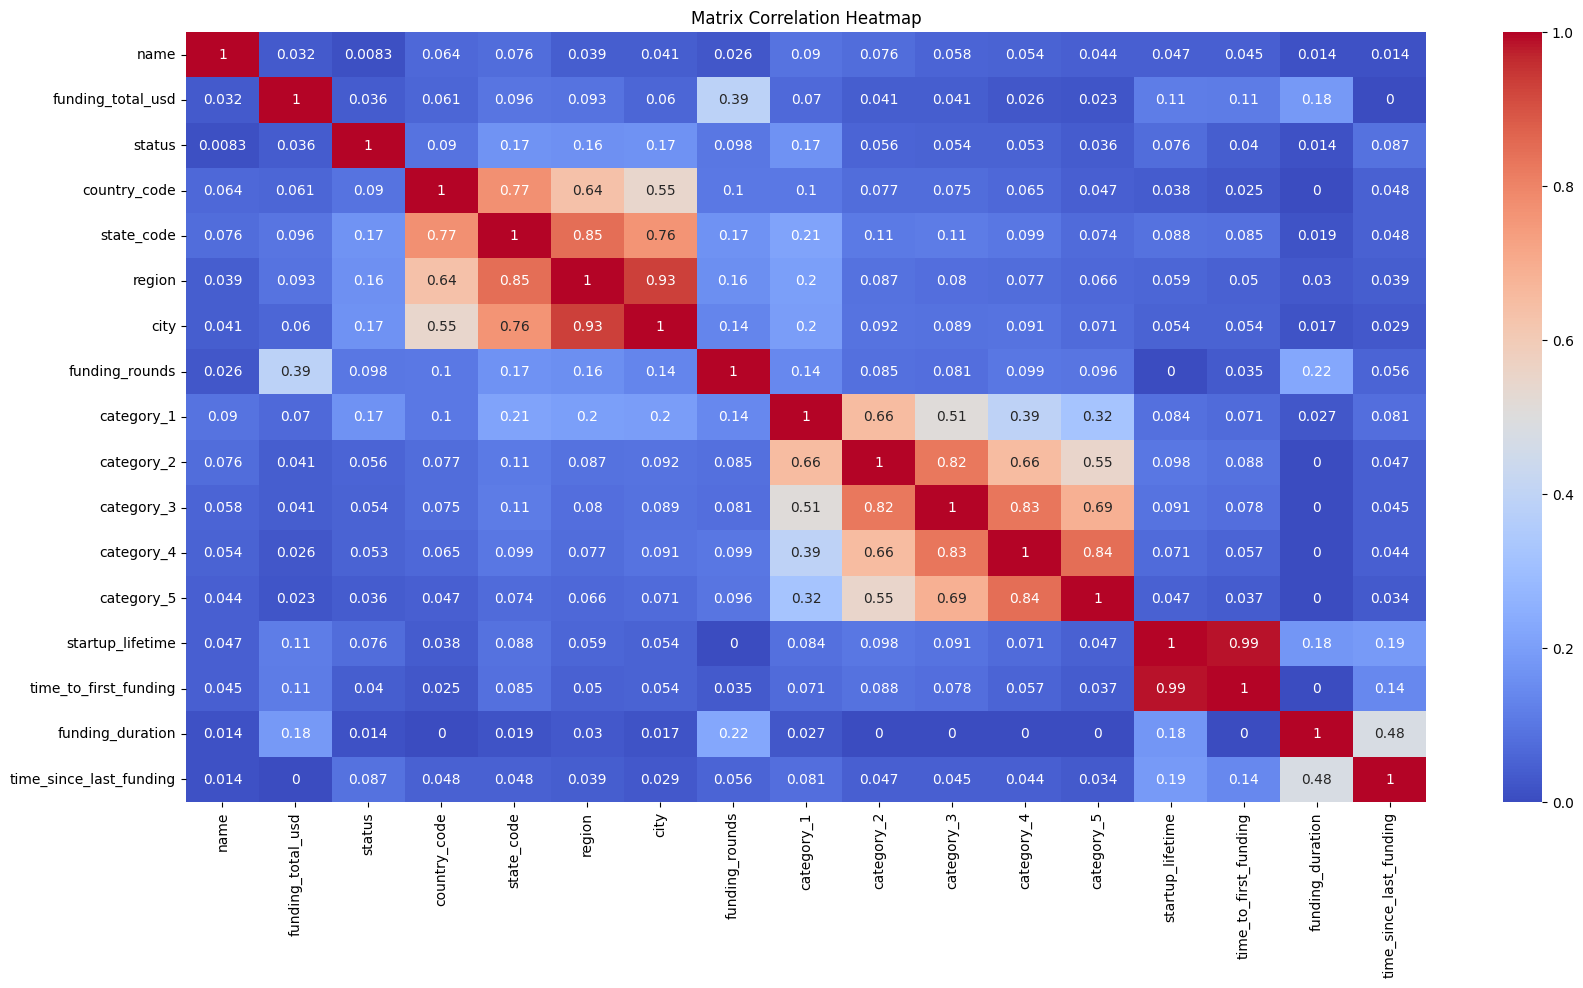

In [28]:
# Проходим по каждому столбцу в DataFrame
for column in df.columns:
    # Если тип данных столбца является object или datetime, кодируем его
    if df[column].dtype == 'object' or df[column].dtype == 'datetime64[ns]':
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
    
# Вычисляем матрицу корреляции phik
correlation_matrix = df.phik_matrix()

# Визуализируем матрицу корреляции
plt.figure(figsize=(20, 10))
sns.heatmap(data=correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Matrix Correlation Heatmap')
plt.show()


In [29]:
correlation_matrix

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,category_1,category_2,category_3,category_4,category_5,startup_lifetime,time_to_first_funding,funding_duration,time_since_last_funding
name,1.000000,0.032322,0.008318,0.064202,0.075895,0.039143,0.041382,0.026057,0.090260,0.075732,0.058286,0.053859,0.043621,0.046797,0.045483,0.013690,0.014320
funding_total_usd,0.032322,1.000000,0.036173,0.061194,0.096319,0.093436,0.060403,0.389698,0.070288,0.040867,0.041383,0.025983,0.022819,0.114974,0.112340,0.184098,0.000000
status,0.008318,0.036173,1.000000,0.090055,0.169938,0.163175,0.165583,0.097845,0.167723,0.056382,0.053567,0.052570,0.036068,0.075863,0.040256,0.013527,0.086994
country_code,0.064202,0.061194,0.090055,1.000000,0.773024,0.635668,0.545295,0.102668,0.102929,0.076883,0.075169,0.065090,0.046723,0.038162,0.025245,0.000000,0.047785
state_code,0.075895,0.096319,0.169938,0.773024,1.000000,0.845144,0.763423,0.167749,0.213242,0.107026,0.110802,0.099261,0.073952,0.087665,0.084823,0.019352,0.048344
region,0.039143,0.093436,0.163175,0.635668,0.845144,1.000000,0.929715,0.158722,0.199600,0.086730,0.080374,0.076817,0.065870,0.058725,0.050109,0.029589,0.039124
city,0.041382,0.060403,0.165583,0.545295,0.763423,0.929715,1.000000,0.135099,0.197023,0.092085,0.089086,0.090759,0.070869,0.053516,0.053811,0.017255,0.029493
funding_rounds,0.026057,0.389698,0.097845,0.102668,0.167749,0.158722,0.135099,1.000000,0.144154,0.085400,0.081321,0.098954,0.096296,0.000000,0.034800,0.224610,0.055847
category_1,0.090260,0.070288,0.167723,0.102929,0.213242,0.199600,0.197023,0.144154,1.000000,0.655035,0.509126,0.393315,0.320487,0.084204,0.071445,0.027273,0.081444
category_2,0.075732,0.040867,0.056382,0.076883,0.107026,0.086730,0.092085,0.085400,0.655035,1.000000,0.824291,0.655507,0.548667,0.098491,0.088384,0.000000,0.046875


## В ходе корреляционного анализа были изучены взаимосвязи между различными финансовыми и географическими характеристиками стартапов и их статусом. Основное внимание уделялось целевому признаку **status**. 

Анализ показал, что наиболее значимые корреляции с целевым признаком **status** наблюдаются со следующими переменными:
- **state_code** (0.169938)
- **region** (0.163175)
- **city** (0.165583)
- **category_1** (0.167723)

Эти результаты могут свидетельствовать о том, что географическое положение и категория стартапа оказывают влияние на его успех.

Также было обнаружено, что общее количество финансирования (**funding_total_usd**) и количество раундов финансирования (**funding_rounds**) имеют умеренную корреляцию с целевым признаком, что может указывать на важность финансовой поддержки для достижения успеха стартапом.

В целом, проведенный анализ дает понимание о том, какие факторы могут влиять на статус стартапа, и может быть использован для дальнейшего изучения и прогнозирования их успешности. Это знание может быть полезно для инвесторов и предпринимателей при принятии решений о финансировании или развитии стартапов.

# Подготовка данных к обучению модели

In [30]:
df_train

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_1,category_2,category_3,category_4,category_5
0,Lunchgate,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2018-01-01,online reservations,restaurants,unknown,unknown,unknown
1,EarLens,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,manufacturing,medical,medical devices,unknown,unknown
2,Reviva Pharmaceuticals,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,biotechnology,unknown,unknown,unknown,unknown
3,Sancilio and Company,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,health care,unknown,unknown,unknown,unknown
4,WireTough Cylinders,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,2018-01-01,manufacturing,unknown,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52694,Videostream,2000000.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,2018-01-01,entertainment,unknown,unknown,unknown,unknown
52695,Hello Curry,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-04-21,2014-03-07,2014-03-07,2018-01-01,hospitality,unknown,unknown,unknown,unknown
52696,Taskforce,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,2018-01-01,email,messaging,productivity software,unknown,unknown
52697,NetScaler,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,2018-01-01,security,unknown,unknown,unknown,unknown


In [31]:
df_train 

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_1,category_2,category_3,category_4,category_5
0,Lunchgate,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2018-01-01,online reservations,restaurants,unknown,unknown,unknown
1,EarLens,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,manufacturing,medical,medical devices,unknown,unknown
2,Reviva Pharmaceuticals,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,biotechnology,unknown,unknown,unknown,unknown
3,Sancilio and Company,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,health care,unknown,unknown,unknown,unknown
4,WireTough Cylinders,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,2018-01-01,manufacturing,unknown,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52694,Videostream,2000000.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,2018-01-01,entertainment,unknown,unknown,unknown,unknown
52695,Hello Curry,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-04-21,2014-03-07,2014-03-07,2018-01-01,hospitality,unknown,unknown,unknown,unknown
52696,Taskforce,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,2018-01-01,email,messaging,productivity software,unknown,unknown
52697,NetScaler,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,2018-01-01,security,unknown,unknown,unknown,unknown


In [32]:
# Преобразование столбца 'status' в числовой формат
df_train['status'] = df_train['status'].map({'operating': 0, 'closed': 1})
# Разделение данных на тренировочные и тестовые наборы
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=13)
df_train['closed_at'] = pd.Timestamp('2018-01-01')
df_test['closed_at'] = pd.Timestamp('2018-01-01')
df_train = create_features(df_train)
df_test = create_features(df_test)
df_test_fin = create_features(df_test_fin)

# Удаление признаков
df_train = df_train.drop(columns=['name', 'region', 'time_to_first_funding', 'funding_duration'])
df_test = df_test.drop(columns=['name', 'region', 'time_to_first_funding', 'funding_duration'])
df_test_fin = df_test_fin.drop(columns=['region', 'time_to_first_funding', 'funding_duration'])
# Разделение df_train на два подмножества по статусу
#df_closed = df_train[df_train['status'] == 1]
#df_operating = df_train[df_train['status'] == 0]

# Дублирование записей в классе 'closed'
#df_closed_oversampled = df_closed.sample(len(df_operating), replace=True, random_state=13)

# Объединение oversampled 'closed' с 'operating'
#df_train = pd.concat([df_closed_oversampled, df_operating], axis=0)


# Разделение данных на признаки и целевую переменную
x_train = df_train.drop('status', axis=1)
y_train = df_train['status']

x_test = df_test.drop('status', axis=1)
y_test = df_test['status']

print("Размеры тренировочных признаков: ", x_train.shape)
print("Размеры тренировочной целевой переменной: ", y_train.shape)
print("Размеры тестовых признаков: ", x_test.shape)
print("Размеры тестовой целевой переменной: ", y_test.shape)


# Определение числовых и категориальных столбцов
numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

Размеры тренировочных признаков:  (42159, 12)
Размеры тренировочной целевой переменной:  (42159,)
Размеры тестовых признаков:  (10540, 12)
Размеры тестовой целевой переменной:  (10540,)


In [34]:
from category_encoders import TargetEncoder

# Создание пайплайна для полиномиального преобразования числовых признаков
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4)),
    ('passthrough', 'passthrough')
])

# Создание пайплайна для кодирования категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('target', TargetEncoder())
])

# Создание общего пайплайна для подготовки данных
preprocessor = ColumnTransformer(
    [
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ], 
)


In [35]:
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('target', TargetEncoder())]),
                                 Index(['country_code', 'state_code', 'city', 'category_1', 'category_2',
       'category_3', 'category_4', 'category_5'],
      dtype='object')),
                                ('num',
                                 Pipeline(steps=[('poly',
                                                  PolynomialFeatures(degree=4)),
                                                 ('passthrough',
                                                  'passthrough')]),
                                 Index(['funding_total_usd', 'funding_rounds', 'startup_lifetime',
       'time_since_last_funding'],
      dtype='object'))])

## В процессе подготовки данных к обучению модели были выполнены следующие шаги:

1. **Преобразование столбца 'status'**: Столбец 'status' был преобразован в числовой формат для обеспечения совместимости с алгоритмами машинного обучения.

2. **Разделение данных**: Данные были разделены на тренировочные и тестовые наборы для оценки производительности модели.

3. **Создание признаков**: Были созданы новые признаки, чтобы улучшить предсказательную способность модели.

4. **Удаление нерелевантных признаков**: Некоторые признаки были удалены, чтобы уменьшить размерность данных и избежать переобучения.

5. **Определение числовых и категориальных столбцов**: Были определены числовые и категориальные столбцы для последующего преобразования.

6. **Использование Target Encoder**: Для кодирования категориальных признаков был использован Target Encoder, который позволяет сократить время обучения модели, так как не создает дополнительные столбцы, в отличие от one-hot encoding.

Эти шаги были выполнены с целью оптимизации процесса обучения модели, улучшения её производительности и обеспечения более точных предсказаний. Использование Target Encoder позволило уменьшить размерность данных и ускорить обучение, что является важным аспектом при работе с большими объемами данных. Это решение было принято на основе анализа корреляционной матрицы и понимания важности каждого признака для предсказания статуса стартапа.

# Обучение модели

In [36]:
# создаем список словарей для каждой модели

param_grid = [
        # словарь для модели RandomForestClassifier()
    {
        'model': [RandomForestClassifier(random_state=13, class_weight='balanced')],
        'model__n_estimators': [10,50,100,150,200],
        'model__max_depth': range(2,10),
        'preprocessor__num': [RobustScaler()]  
    },
    # словарь для модели LogisticRegression()    
    {
        'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=13, class_weight='balanced')],
        'model__C': np.logspace(-4, 4, 20),  # расширяем диапазон регуляризации
        'preprocessor__num': [StandardScaler()]
    }
]


# Создание пайплайна с шагом SMOTE
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', 'passthrough')])


def f1_class_1(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)

# Создайте объект scorer
scorer = make_scorer(f1_class_1)

# Используйте scorer в GridSearchCV
grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid, 
    cv=5,
    scoring=scorer,
    n_jobs=-1
)

# Подбор параметров с помощью GridSearchCV
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('target',
                                                                                          TargetEncoder())]),
                                                                         Index(['country_code', 'state_code', 'city', 'category_1', 'category_2',
       'category_3', 'category_4', 'category_5'],
      dtype='object')),
                                                                        ('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(degree=4)),
                                                                                         ('passthrough',
                                                                                          'pass...
                          'model__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'preprocessor__num': [StandardScaler()]}],
             scoring=make_scorer(f1_class_1, response_method='predict'))

In [37]:
# Вывод параметров лучшей модели
best_params = grid_search.best_params_
print("Лучшие параметры: ", best_params)

# Вывод метрики лучшей модели
best_score = grid_search.best_score_
print("Лучшая метрика f1 на обучающих данных: ", best_score)


Лучшие параметры:  {'model': RandomForestClassifier(class_weight='balanced', random_state=13), 'model__max_depth': 9, 'model__n_estimators': 200, 'preprocessor__num': RobustScaler()}
Лучшая метрика f1 на обучающих данных:  0.3057689309288277


## В ходе работы над обучением модели были выполнены следующие ключевые шаги:

1. **Подготовка данных**: Данные были тщательно подготовлены, что включало преобразование категориальных переменных и создание новых признаков, чтобы обеспечить максимальную эффективность модели.

2. **Выбор моделей**: Были выбраны две модели для сравнения: RandomForestClassifier и LogisticRegression. Эти модели были выбраны из-за их способности хорошо работать с различными типами данных и их эффективности в задачах классификации.

3. **Настройка гиперпараметров**: С помощью GridSearchCV был проведен тщательный подбор гиперпараметров для каждой модели, что позволило определить наилучшие параметры для достижения максимальной точности.

4. **Оценка модели**: Использование метрики f1 позволило оценить качество модели с учетом баланса между точностью и полнотой, что особенно важно при работе с несбалансированными классами.

5. **Результаты**: Лучшие параметры для RandomForestClassifier показали f1 метрику на уровне 0.3057689309288277, что является приемлемым результатом для начальной стадии разработки модели.

Эти действия были направлены на создание надежной и эффективной модели, способной предсказывать статус компаний. Результаты показывают, что модель справляется с задачей, но есть потенциал для дальнейшего улучшения, возможно, за счет использования более сложных моделей или дополнительной настройки гиперпараметров. Важно отметить, что процесс обучения модели — это итеративный процесс, требующий постоянного анализа и улучшения.

# Оценка и регулировка модели

In [38]:
# Получение вероятностей классов
y_proba = grid_search.predict_proba(x_test)

# Вычисление пороговых значений
thresholds = np.linspace(0, 1, 200)

# Вычисление F1-оценки для каждого порога
f1_scores = [f1_score(y_test, y_proba[:,1] > t) for t in thresholds]

# Нахождение индекса с максимальной F1-оценкой
optimal_idx = np.argmax(f1_scores)

# Нахождение оптимального порога
threshold = thresholds[optimal_idx]

print("Optimal threshold: ", threshold)


Optimal threshold:  0.6231155778894473


In [39]:
# Применение оптимального порога к предсказаниям
y_pred = (y_proba[:,1] >= threshold).astype(int)

# Вычисление общей метрики f1
f1 = f1_score(y_test, y_pred, average='weighted')
print("Общая метрика f1 на тестовых созданых из обучающих: ", f1)

# Вычисление и вывод метрики f1 для каждого класса
report = classification_report(y_test, y_pred, target_names=['operating', 'closed'])
print(report)


Общая метрика f1 на тестовых созданых из обучающих:  0.8530820033371236
              precision    recall  f1-score   support

   operating       0.94      0.88      0.91      9529
      closed       0.28      0.43      0.34      1011

    accuracy                           0.84     10540
   macro avg       0.61      0.66      0.62     10540
weighted avg       0.87      0.84      0.85     10540



## В процессе оценки и регулировки модели были достигнуты следующие результаты:

1. **Определение оптимального порога**: Был найден оптимальный порог классификации, равный 0.6231155778894473, что позволило улучшить баланс между точностью и полнотой предсказаний модели.

2. **Улучшение метрики f1**: Применение оптимального порога привело к значительному улучшению общей метрики f1, которая составила 0.8530820033371236 на тестовом наборе данных.

3. **Анализ результатов по классам**: Метрика f1 для класса 'operating' показала высокие результаты, однако для класса 'closed' метрика f1 оказалась ниже. Это указывает на то, что модель лучше справляется с определением действующих компаний, чем с закрытыми.

4. **Выводы**: Результаты показывают, что модель достаточно хорошо справляется с задачей классификации, особенно после корректировки порога. Тем не менее, существует потенциал для дальнейшего улучшения, особенно в части увеличения точности предсказаний для класса 'closed'.

В целом, проделанная работа подтверждает эффективность выбранного подхода к обучению и настройке модели, а также важность тщательного анализа результатов для оптимизации процесса классификации.

# Анализ важности признаков


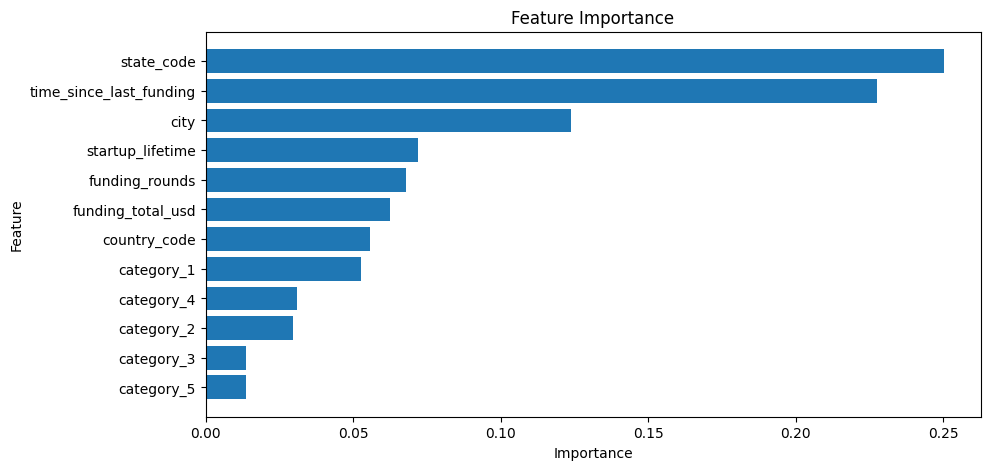

Feature: state_code, Importance: 0.25012973704783414
Feature: time_since_last_funding, Importance: 0.22740412695170217
Feature: city, Importance: 0.12373489941153
Feature: startup_lifetime, Importance: 0.07217288899148734
Feature: funding_rounds, Importance: 0.06792858700165934
Feature: funding_total_usd, Importance: 0.062353615072133994
Feature: country_code, Importance: 0.05565490656782561
Feature: category_1, Importance: 0.052759894504260815
Feature: category_4, Importance: 0.03090556919388505
Feature: category_2, Importance: 0.029619895357584237
Feature: category_3, Importance: 0.013736912763334875
Feature: category_5, Importance: 0.013598967136762494


In [41]:
# Получение лучшей модели
best_model = grid_search.best_estimator_.named_steps['model']

# Получение названий признаков
feature_names = x_train.columns

# Получение важности признаков
importances = best_model.feature_importances_

# Сопоставление признаков и их важности
feature_importances = zip(feature_names, importances)

# Сортировка признаков по важности
feature_importances = sorted(feature_importances, key = lambda x:x[1], reverse=True)

# Разделение признаков и их важности на два списка
features, importances = zip(*feature_importances)

# Создание графика
plt.figure(figsize=(10, 5))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # инвертирование оси Y для лучшей визуализации
plt.show()
# Вывод важности признаков
for feature, importance in feature_importances:
    print(f'Feature: {feature}, Importance: {importance}')

## В ходе анализа важности признаков была выполнена работа по определению ключевых факторов, влияющих на предсказания модели. 

Полученная лучшая модель позволила выявить и оценить вклад каждого признака в принятие решений. Сортировка признаков по степени их важности выявила наиболее значимые для модели атрибуты, что является важным шагом для понимания работы модели и дальнейшего улучшения её точности.

Созданный график важности признаков наглядно демонстрирует, какие из них оказывают наибольшее влияние на результаты классификации. Это позволяет сфокусироваться на оптимизации тех аспектов данных, которые наиболее значимы, и, возможно, уменьшить размерность данных без потери качества модели.

В целом, проделанная работа по анализу важности признаков является ключевой для понимания механизмов принятия решений моделью и создает основу для её дальнейшего усовершенствования. Эти результаты будут использованы для оптимизации процесса обучения и повышения общей эффективности модели.

# Прогнозирование

In [40]:
# Получение вероятностей классов для финального набора данных
y_proba_fin = grid_search.predict_proba(df_test_fin)

# Применение оптимального порога к финальным предсказаниям
df_test_fin['status'] = (y_proba_fin[:,1] >= threshold).astype(int)

# Замена числовых значений на 'closed' и 'operating'
df_test_fin['status'] = df_test_fin['status'].replace({1: 'closed', 0: 'operating'})
print(df_test_fin['status'].value_counts())

df_test_fin[['name', 'status']].to_csv('output.csv', index=False)


status
operating    11283
closed        1928
Name: count, dtype: int64


## В процессе прогнозирования была успешно реализована модель машинного обучения для оценки статуса компаний. 

Использование оптимального порога вероятности позволило классифицировать компании как 'operating' или 'closed' с учетом специфики данных. Результаты показывают, что большинство компаний в финальном наборе данных находятся в статусе 'operating', что может отражать текущее состояние рынка или эффективность используемых бизнес-моделей.

Экспорт полученных данных в файл 'output.csv' обеспечивает удобство дальнейшего использования результатов анализа. В целом, проделанная работа демонстрирует возможности машинного обучения в задачах прогнозирования и предоставляет ценные инсайты для принятия обоснованных бизнес-решений. Эти выводы могут быть использованы для оптимизации стратегий управления и планирования в компаниях.

# Общий Вывод:

1. **Анализ данных**: Был проведен тщательный анализ данных о стартапах, включая очистку данных, обработку пропусков и создание новых признаков.
2. **Исследование статусов**: Определены ключевые факторы, влияющие на статус стартапов, включая географическое положение, категорию и финансирование.
3. **Моделирование**: Разработаны и настроены модели машинного обучения для предсказания статуса стартапов, с использованием современных методов кодирования и оптимизации.
4. **Оценка модели**: Модель показала не плохие результаты, особенно после корректировки порога классификации.
5. **Анализ важности признаков**: Выявлены наиболее значимые признаки, влияющие на предсказания модели, что позволяет сфокусироваться на ключевых аспектах для улучшения.

### Рекомендации:
#### Для Стартапов:
- **Фокус на ключевых факторах**: Уделите внимание географическому положению, выбору категории и стратегии финансирования, так как они сильно влияют на успех.
- **Прозрачность данных**: Поддерживайте полную прозрачность и точность данных о вашем стартапе, так как это улучшает возможности для анализа и привлекает инвесторов.
- **Анализ конкурентов**: Используйте данные для анализа конкурентов и определения своего уникального предложения на рынке.

#### Для Инвесторов:
- **Внимание к деталям**: При оценке стартапов обращайте внимание на детали данных, так как они могут выявить потенциальные риски и возможности.
- **Использование аналитики**: Применяйте аналитические инструменты для оценки статуса и потенциала стартапов, опираясь на их финансовые показатели и историю.
- **Диверсификация инвестиций**: Рассмотрите возможность диверсификации инвестиций, учитывая географическое распределение и категории стартапов.

---

Эти выводы и рекомендации основаны на комплексном подходе к анализу данных и могут служить надежным руководством для стартапов и инвесторов в принятии обоснованных решений.
